In [1]:
#@title Preparing the Image Data
# Loading files from Google Drive
# Data : [https://drive.google.com/drive/folders/1yOZWIk8amCkgVeVDJjZawFG7FE9qQoA2?usp=sharing]
from google.colab import drive
drive.mount('/content/drive/')

# Importing the libraries
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# Preparing the data
# The training set preprocessing
training_set_path = '/content/drive/MyDrive/Data/Dog or Cat/training_set'
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory(training_set_path,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

# The test set preprocessing
test_set_path = '/content/drive/MyDrive/Data/Dog or Cat/test_set'
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_set_path,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')


Mounted at /content/drive/
Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [2]:
#@title Building the Convolutional Neural Network
import tensorflow.keras.layers as F
def make_model():
  """
  Builds a Convolutional Neural Network as
  (I) Initializing a Sequential model,
  (II) 2 Convolutional layers with 32 filters and 2 MaxPooling,
  (III) Flattens the output of second pooling,
  (IV) Fully connects the flattened data to Dense layer with 128 units,
  (V) Output layer with 1 class as [1, 0],
  (VI) Compiles the model with Adam optimizer 
       binary crossentropy loss function, and
       AUC as metric.
  returns the built model
  """
  model = tf.keras.models.Sequential()
  model.add(F.Conv2D(filters = 32, 
                     kernel_size = (3, 3),
                     strides = (2, 2),
                     activation = 'relu',
                     input_shape = (64, 64 , 3)))
  model.add(F.MaxPool2D(pool_size = (2, 2), 
                        strides = (2, 2)))
  model.add(F.Conv2D(filters = 32, 
                     kernel_size = (3, 3),
                     strides = (2, 2),
                     activation = 'relu')) 
  model.add(F.MaxPool2D(pool_size = (2, 2), 
                        strides = (2, 2)))
  model.add(F.Flatten()) 
  model.add(F.Dense(units = 128, activation = 'relu')) 
  model.add(F.Dense(units = 1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['AUC'])
  return model

In [4]:
#@title Training the CNN
cnn = make_model()
cnn.fit(x = training_set, 
        validation_data = test_set, 
        epochs = 25)

# Saving the model
cnn.save("/content/drive/MyDrive/Data/Dog or Cat/cat_or_dog_identifier")

Epoch 1/25
250/250 [==============================] - 2201s 9s/step - loss: 0.6892 - auc: 0.5510 - val_loss: 0.6659 - val_auc: 0.6656
Epoch 2/25
250/250 [==============================] - 55s 222ms/step - loss: 0.6424 - auc: 0.6807 - val_loss: 0.6557 - val_auc: 0.7317
Epoch 3/25
250/250 [==============================] - 55s 221ms/step - loss: 0.6052 - auc: 0.7329 - val_loss: 0.5922 - val_auc: 0.7649
Epoch 4/25
250/250 [==============================] - 54s 218ms/step - loss: 0.5787 - auc: 0.7634 - val_loss: 0.5713 - val_auc: 0.7888
Epoch 5/25
250/250 [==============================] - 57s 229ms/step - loss: 0.5675 - auc: 0.7771 - val_loss: 0.5685 - val_auc: 0.7997
Epoch 6/25
250/250 [==============================] - 57s 228ms/step - loss: 0.5474 - auc: 0.7953 - val_loss: 0.5331 - val_auc: 0.8158
Epoch 7/25
250/250 [==============================] - 58s 234ms/step - loss: 0.5405 - auc: 0.8021 - val_loss: 0.5360 - val_auc: 0.8180
Epoch 8/25
250/250 [==============================] - 57

In [ ]:
#@title Making few predictions
import numpy as np
import pandas as pd
from keras.preprocessing import image

from PIL import Image
from io import BytesIO
from IPython.display import HTML
import base64

pd.set_option('display.max_colwidth', 0)
def get_thumbnail(path):
    i = Image.open(path)    
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}" width="150" height="150">'

# Gettting the paths into a DataFrame
path_ = "/content/drive/MyDrive/Data/Dog or Cat/single_prediction/cat_or_dog_"
P = {i : path_ + str(i) + '.jpg' for i in range(1, 9)}
# Creating the dataframe for results
df = pd.DataFrame(P,
                  index = ['imageLocal']).T
df['Photos'] = df.imageLocal.map(lambda f: get_thumbnail(f))
df = df.drop(columns = 'imageLocal')
df['True value'] = ['Dog', 'Cat', 'Dog', 'Cat', 'Dog', 'Cat', 'Dog', 'Cat']
df = df.reindex(sorted(df.columns), axis=1)

# Making the predictions
training_set.class_indices
prediction = []
for i, path in P.items():
  test_image = image.load_img(path, target_size = (64, 64))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  result = cnn.predict(test_image)
  prediction.append(['Cat', 'Dog'][result[0][0] == 1])
df['Prediction'] = prediction

,Photos,True value,Prediction
1,,Dog,Dog
2,,Cat,Cat
3,,Dog,Cat
4,,Cat,Dog
5,,Dog,Dog
6,,Cat,Cat
7,,Dog,Dog
8,,Cat,Dog

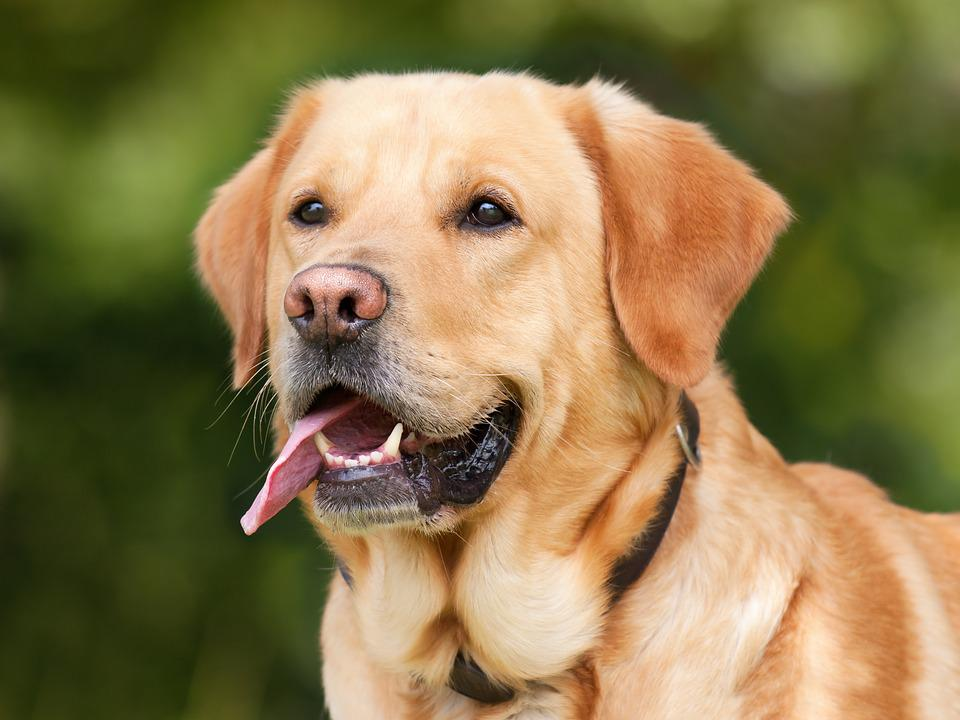
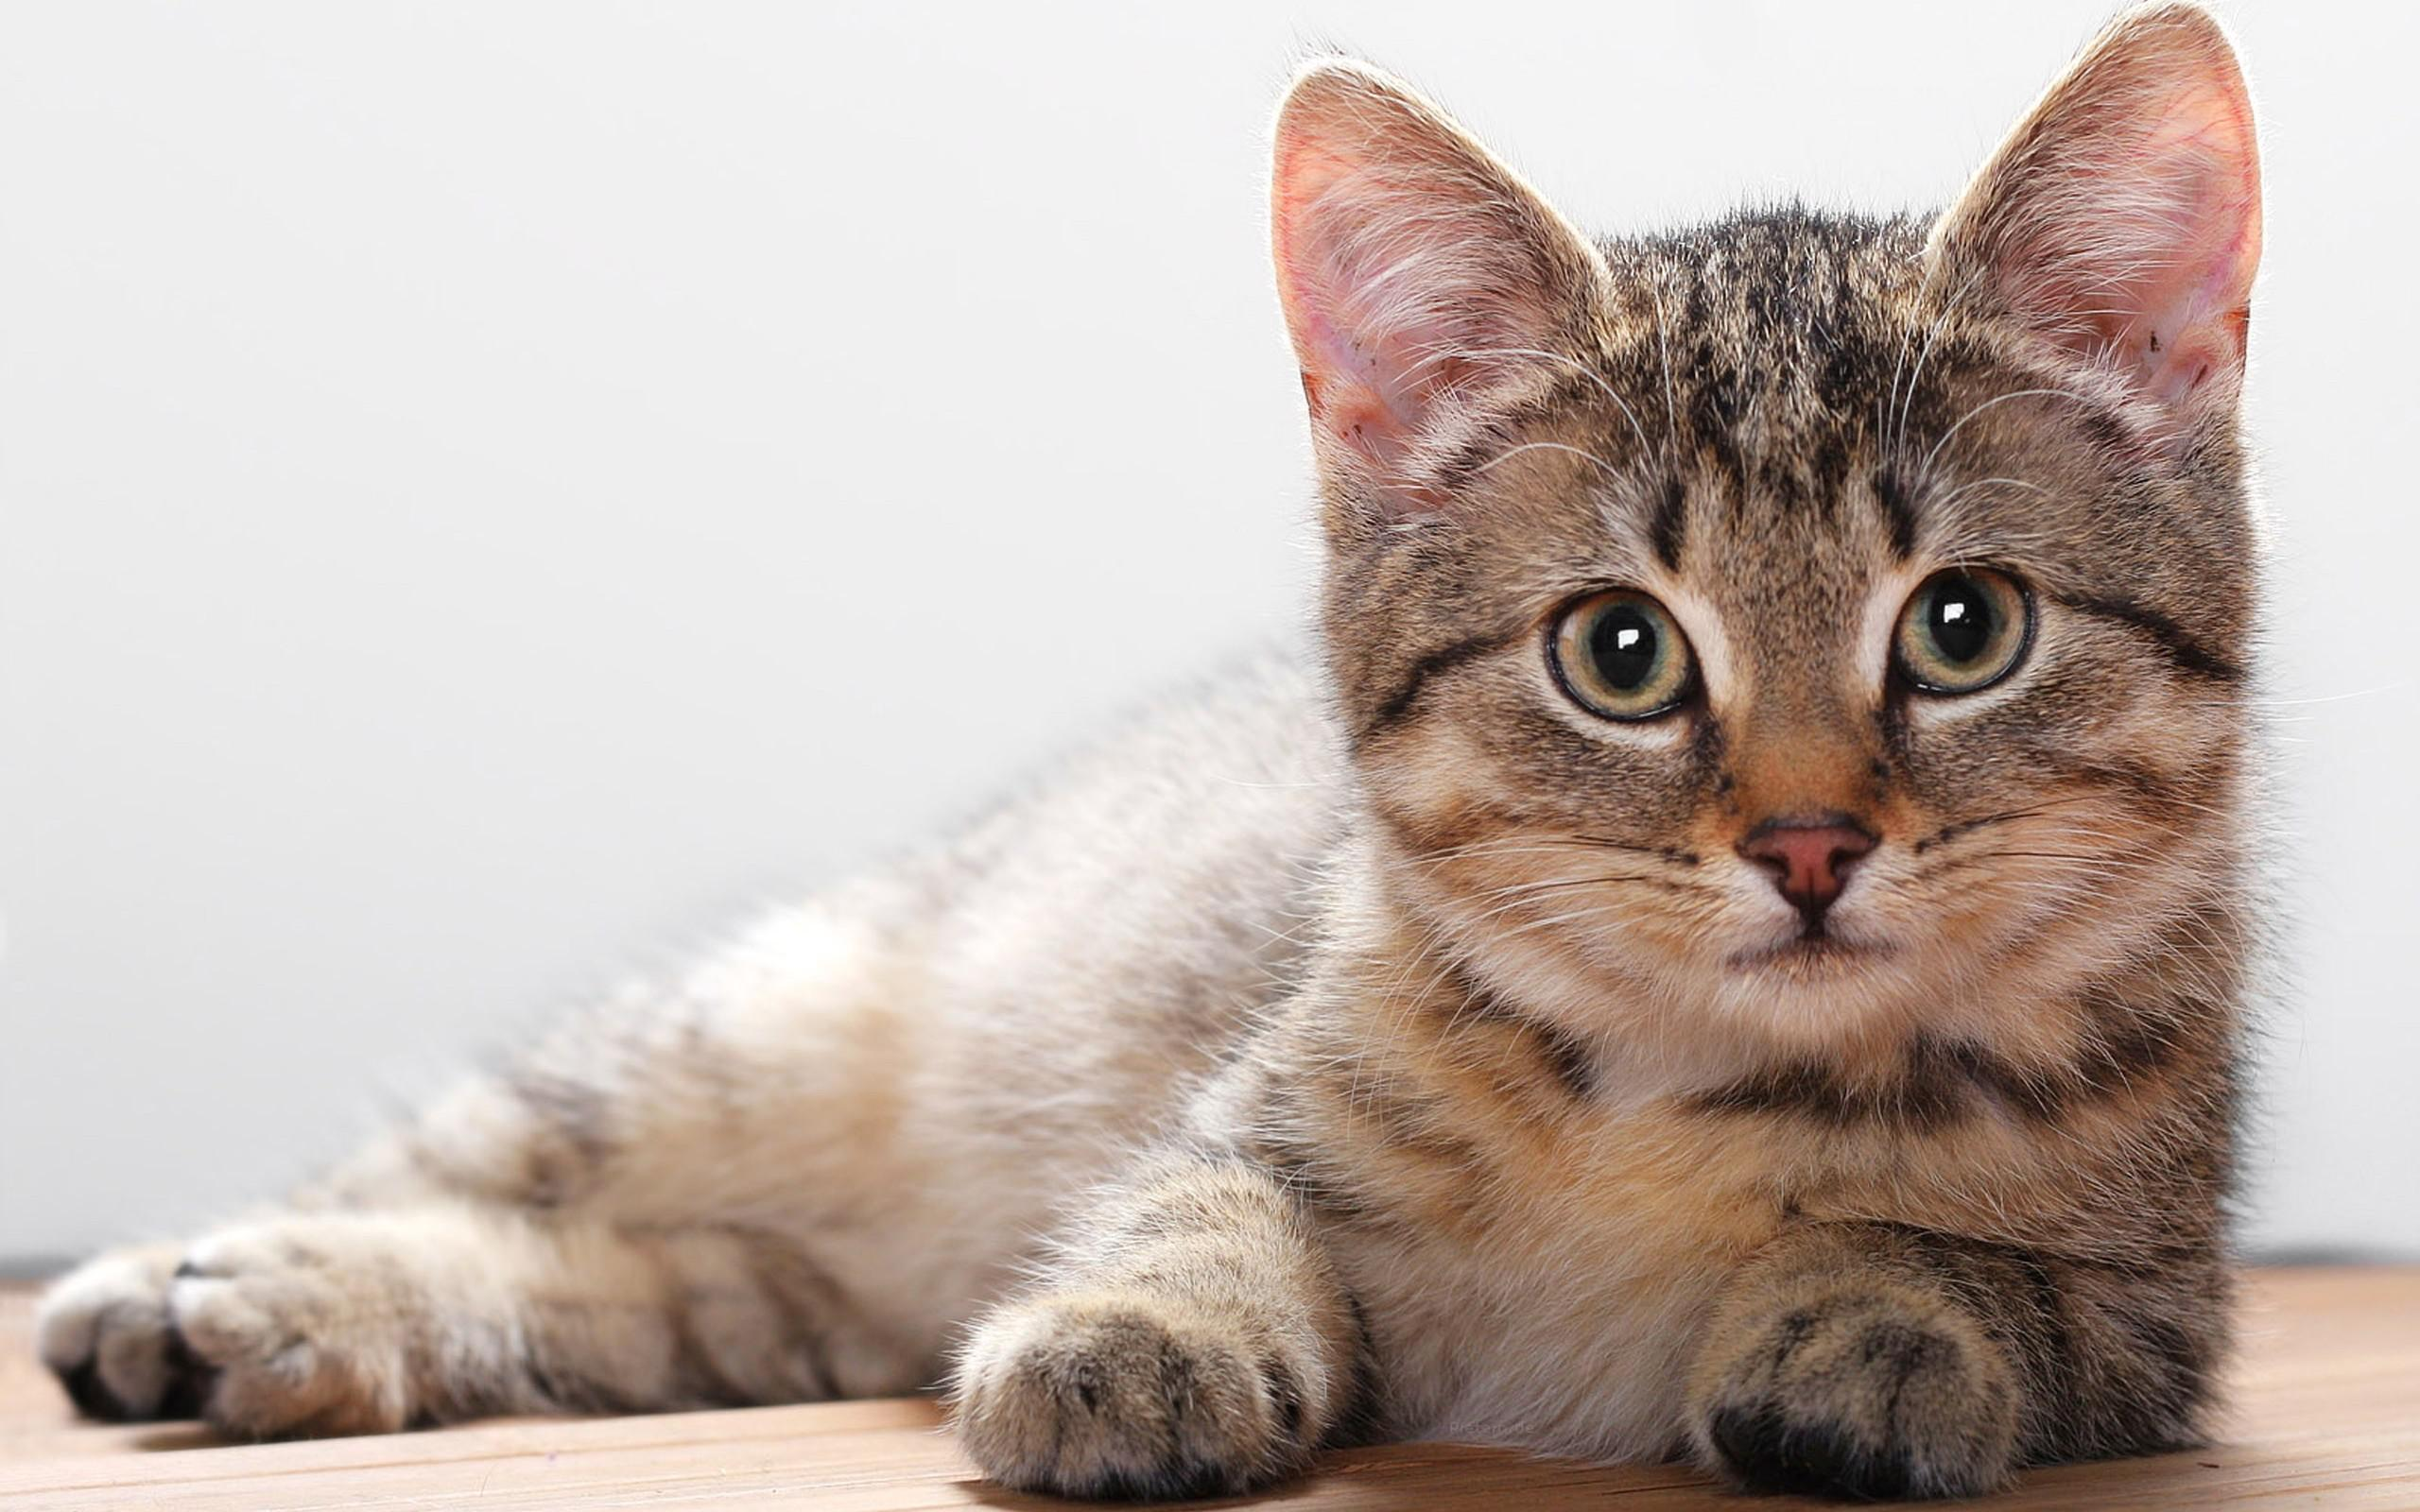
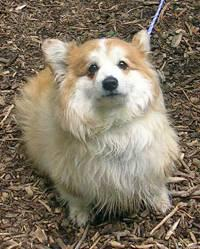
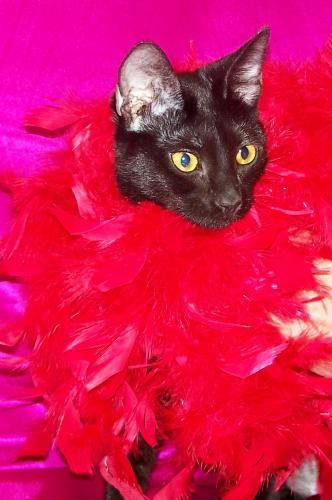
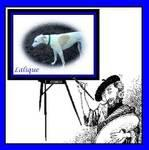
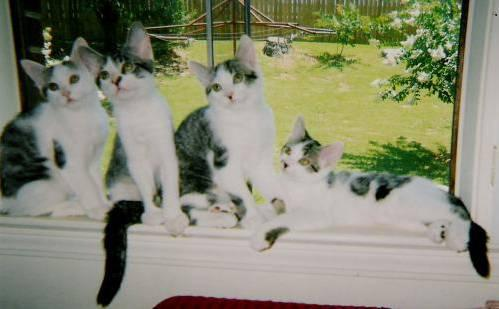
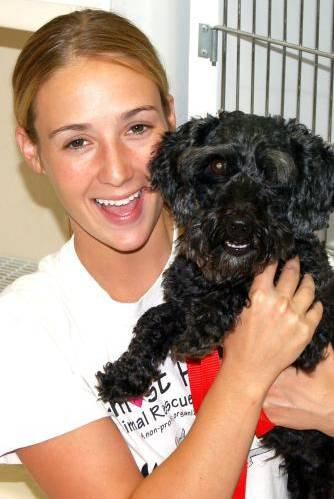
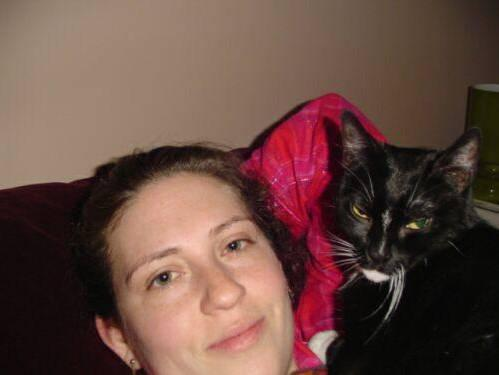

In [103]:
#@title Results
HTML(df.to_html(formatters={'Photos': image_formatter}, escape=False))